In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve,auc

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from collections import Counter


import keras
from keras import models
from keras import layers
import tensorflow as tf
from keras.backend import binary_crossentropy
from keras import backend as K
from keras.callbacks import Callback
from keras import optimizers
from keras.backend import mean
from keras import regularizers
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import load_model

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
K.clear_session()

W1002 21:50:01.904476 139994049017664 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W1002 21:50:01.905476 139994049017664 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W1002 21:50:01.908742 139994049017664 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.



In [3]:
path = '/home/ricardo/TCC/'
df = pd.read_csv(path+'train.csv', sep = ',')
X = df.loc[:,'var_0':'var_199']
Y = df.loc[:,'target']

In [4]:
meanX = X.mean(axis = 0)
stdX = X.std(axis = 0)
X_norm = (X-meanX)/stdX

In [5]:
fraud_index = np.where(Y==1)
honest_index = np.where(Y==0)
fraud = X_norm.loc[fraud_index]
honest = X_norm.loc[honest_index]

yh = Y.loc[honest_index]
yf = Y.loc[fraud_index]

In [6]:
h_used, x_trash, yh, y_trash = train_test_split(honest, yh, test_size = 0.75, random_state = 30)
x_used = pd.concat([h_used,fraud],ignore_index = False)
y_used = pd.concat([yh,yf],ignore_index=False)
x_train,x_test,y_train,y_test = train_test_split(x_used,y_used,test_size=0.3,random_state = 30)
x_val,x_test,y_val,y_test = train_test_split(x_test,y_test,test_size=0.5,random_state = 30)

In [7]:
x_data = [x_train,x_val,x_test]
y_data = [y_train,y_val,y_test]

print('Size of Train Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[0]),Counter(y_data[0])))
print('Size of val Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[1]),Counter(y_data[1])))
print('Size of test Data: {0}, not anomalys/anomaly:{1}'.format(len(x_data[2]),Counter(y_data[2])))

Size of Train Data: 45551, not anomalys/anomaly:Counter({0: 31412, 1: 14139})
Size of val Data: 9761, not anomalys/anomaly:Counter({0: 6779, 1: 2982})
Size of test Data: 9761, not anomalys/anomaly:Counter({0: 6784, 1: 2977})


In [8]:
def f1Score(y_true, y_pred):
    def recall(y_true, y_pred):
        """Recall metric.

        Only computes a batch-wise average of recall.

        Computes the recall, a metric for multi-label classification of
        how many relevant items are selected.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """Precision metric.

        Only computes a batch-wise average of precision.

        Computes the precision, a metric for multi-label classification of
        how many selected items are relevant.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision
    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [9]:
from sklearn.utils.multiclass import unique_labels
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [10]:
def choosing_threshold(y_true,y_prob,threshold_list):
    y_hat = []
    precision = []
    recall = []
    f1 = []
    y_h = []
    for threshold in threshold_list:
        for i in range(len(y_true)):
            if y_prob[i]>threshold:
                y_hat.append(1)
            else:
                y_hat.append(0)
        precision.append(precision_score(y_true,y_hat))
        recall.append(recall_score(y_true,y_hat))
        f1.append(f1_score(y_true,y_hat))
        y_h.append(y_hat)
        y_hat = []
    return(precision,recall,f1,y_h)           

In [11]:
model = models.Sequential()
model.add(layers.Dense(units = 100, activation='tanh',input_shape = (200,),
                       kernel_regularizer=regularizers.l2(0.001)))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 100, activation='tanh',kernel_regularizer=regularizers.l2(0.001)))
BatchNormalization(axis=1)
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units = 1,activation = 'sigmoid'))
model.summary()

W1001 22:30:00.172634 139796830897984 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1001 22:30:00.175144 139796830897984 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1001 22:30:00.198526 139796830897984 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 30,301
Trainable params: 30,301
Non-trainable params: 0
_________________________________________________________________


In [12]:
mom = optimizers.SGD(lr=0.0001, decay=0, momentum=0.9, nesterov=True)
model.compile(loss = 'binary_crossentropy',metrics=[f1Score],optimizer = mom)
history = model.fit(x_train,y_train,epochs = 2000, validation_data =(x_val, y_val),verbose = 0)

W1001 22:30:00.289600 139796830897984 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1001 22:30:00.310775 139796830897984 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


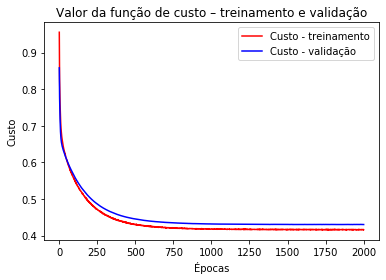

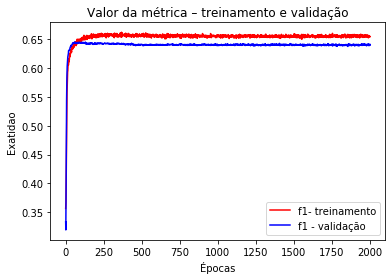

In [13]:
# Salva treinamento na variável history para visualização
history_dict = history.history
# Salva custos, métricas e epocas em vetores
custo = history_dict['loss']
metrica = history_dict['f1Score']
val_custo = history_dict['val_loss']
val_metrica = history_dict['val_f1Score']
# Cria vetor de épocas
epocas = range(1, len(custo) + 1)
# Gráfico dos valores de custo
plt.plot(epocas, custo, 'b', label='Custo - treinamento',color = 'red')
plt.plot(epocas, val_custo, 'b', label='Custo - validação')
plt.title('Valor da função de custo – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Custo')
plt.legend()
plt.show()
# Gráfico dos valores da métrica
plt.plot(epocas, metrica, 'b', label='f1- treinamento',color = 'red')
plt.plot(epocas, val_metrica, 'b', label='f1 - validação')
plt.title('Valor da métrica – treinamento e validação')
plt.xlabel('Épocas')
plt.ylabel('Exatidao')
plt.legend()
plt.show()

In [14]:
prob = np.ravel(model.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.05)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)
print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [0.43703317133631236, 0.48825827990439696, 0.5335266871564002, 0.5764671304007054, 0.615001934663645, 0.6494921514312096, 0.6833471188309898, 0.7153988582008949, 0.745803772278941, 0.7768724845391185, 0.804640215198386, 0.8284868759650026, 0.8553030303030303, 0.8766151046405823, 0.9025735294117647, 0.926706511481598, 0.9534648457258472, 0.9856957087126138]
recall values: [0.9476624938114435, 0.9102482495225971, 0.8717023834783224, 0.8323078011174765, 0.786901478180918, 0.7462338213452153, 0.7011811302072283, 0.655845533630384, 0.6096612207369687, 0.5597284107786972, 0.5077445363887121, 0.4554070302001556, 0.39925030058702876, 0.3406888747436169, 0.27781314095763493, 0.20835985571822618, 0.13331918806139048, 0.05361058066341325]
f1 values: [0.5981963480512523, 0.635586942565065, 0.6619226638023631, 0.6811564842415998, 0.6904126590133417, 0.6945102685624013, 0.692149265193563, 0.6843289915501273, 0.6708954352648169, 0.6506618432952397, 0.6226096006244308, 0.587741317146

Normalized confusion matrix
[[0.45052846 0.54947154]
 [0.05233751 0.94766249]]
Normalized confusion matrix
[[0.57057812 0.42942188]
 [0.08975175 0.91024825]]
Normalized confusion matrix
[[0.65694639 0.34305361]
 [0.12829762 0.87170238]]
Normalized confusion matrix
[[0.72475487 0.27524513]
 [0.1676922  0.8323078 ]]
Normalized confusion matrix
[[0.77826945 0.22173055]
 [0.21309852 0.78690148]]
Normalized confusion matrix
[[0.81873169 0.18126831]
 [0.25376618 0.74623382]]
Normalized confusion matrix
[[0.85375016 0.14624984]
 [0.29881887 0.70118113]]
Normalized confusion matrix
[[0.8825608  0.1174392 ]
 [0.34415447 0.65584553]]
Normalized confusion matrix
[[0.90646887 0.09353113]
 [0.39033878 0.60966122]]
Normalized confusion matrix
[[0.92763912 0.07236088]
 [0.44027159 0.55972841]]
Normalized confusion matrix
[[0.94451165 0.05548835]
 [0.49225546 0.50774454]]
Normalized confusion matrix
[[0.95756399 0.04243601]
 [0.54459297 0.45540703]]
Normalized confusion matrix
[[0.96959761 0.03040239]

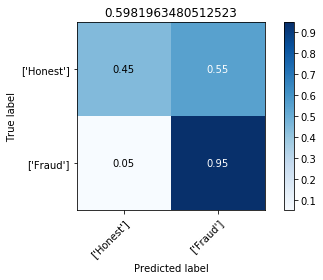

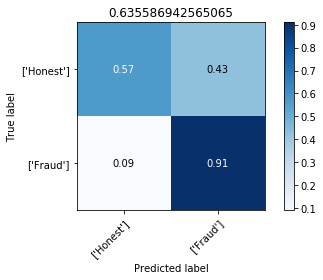

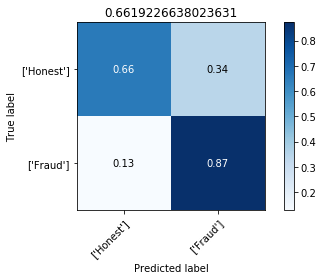

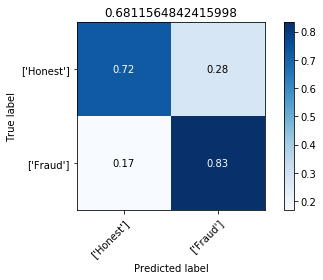

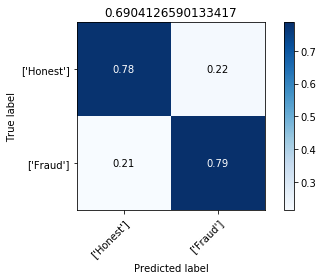

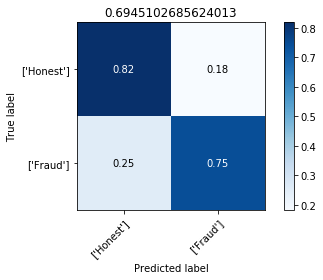

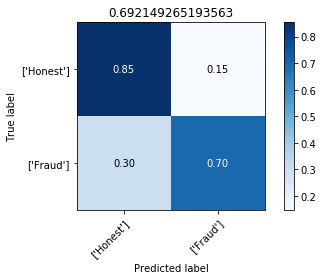

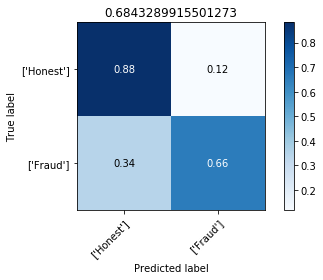

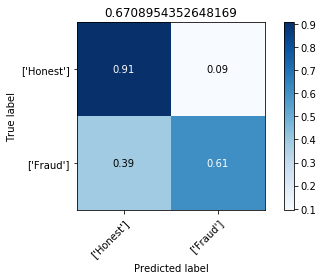

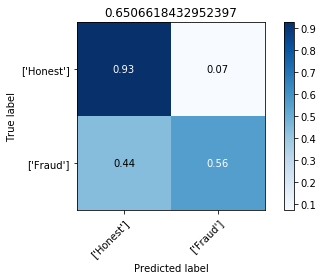

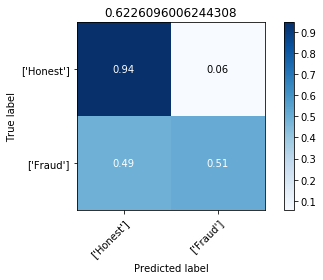

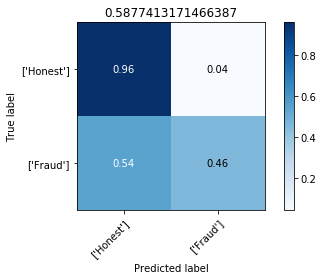

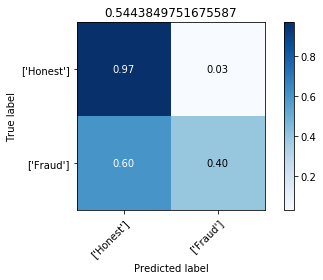

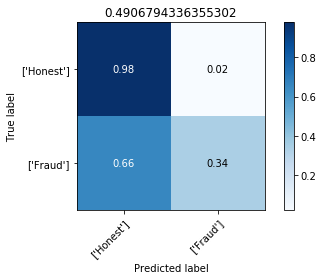

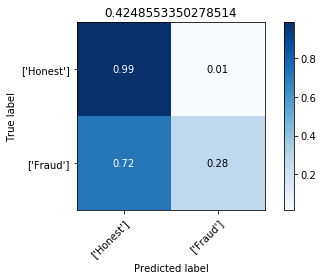

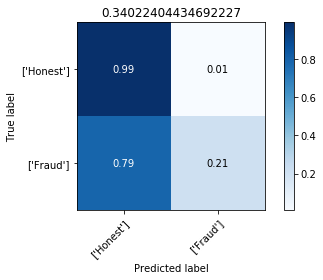

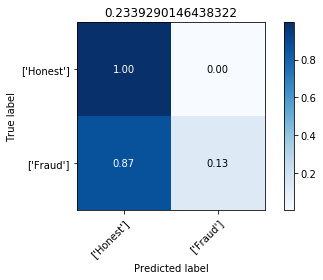

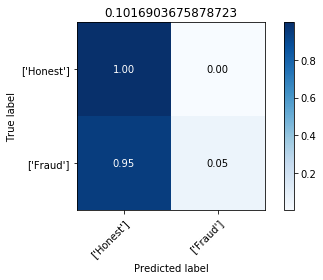

In [15]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)

In [11]:
model.save('/home/ricardo/TCC/Undersampling/models/RNA3/RNA3.h5')

NameError: name 'model' is not defined

In [12]:
model = load_model(path+'Undersampling/models/RNA3/RNA3.h5', custom_objects={'f1Score': f1Score})

W1002 21:51:04.709522 139994049017664 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1002 21:51:04.712548 139994049017664 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1002 21:51:04.743157 139994049017664 deprecation.py:506] From /usr/local/lib/python3.7/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1002 21:51:04.868987 139994049017664 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/dist-packages/keras/optimizers.py:790: The name tf.tra

In [15]:
prob = np.ravel(model.predict(x_data[0]))
threshold_list = np.arange(0.1,1,0.01)
precision,recall,f1,yprob = choosing_threshold(y_data[0],prob,threshold_list)
print('precision values: {}'.format(precision))
print('recall values: {}'.format(recall))
print('f1 values: {}'.format(f1))

precision values: [0.43703317133631236, 0.44827818586158097, 0.45860558876685664, 0.46927574703160313, 0.47876618824484374, 0.48825827990439696, 0.49810716934004606, 0.5070134658544405, 0.5169247240981716, 0.5251953537486801, 0.5335266871564002, 0.5421045629905548, 0.5509758427733042, 0.5595992544268407, 0.5686349509921109, 0.5764671304007054, 0.584612298124185, 0.5922085921059385, 0.6006007588532883, 0.6074746165478505, 0.615001934663645, 0.622004972875226, 0.628955878955879, 0.6361650628726607, 0.6432015429122468, 0.6494921514312096, 0.6560750015730196, 0.6623393316195373, 0.6696052631578947, 0.6760449619707882, 0.6833471188309898, 0.6898716321060798, 0.6964041219283706, 0.7036736500442609, 0.7098429951690821, 0.7153988582008949, 0.7204513176581979, 0.7266645171691117, 0.7340830163717545, 0.7401541458456847, 0.745803772278941, 0.7516391990076201, 0.7577104499274311, 0.7638345444382336, 0.7715925394548063, 0.7768724845391185, 0.7816717019133937, 0.787819253438114, 0.7937685459940653, 

Normalized confusion matrix
[[0.45052846 0.54947154]
 [0.05233751 0.94766249]]
Normalized confusion matrix
[[0.47873424 0.52126576]
 [0.05905651 0.94094349]]
Normalized confusion matrix
[[0.50410671 0.49589329]
 [0.06676568 0.93323432]]
Normalized confusion matrix
[[0.52900166 0.47099834]
 [0.07475776 0.92524224]]
Normalized confusion matrix
[[0.55026741 0.44973259]
 [0.08225476 0.91774524]]
Normalized confusion matrix
[[0.57057812 0.42942188]
 [0.08975175 0.91024825]]
Normalized confusion matrix
[[0.59060232 0.40939768]
 [0.09731947 0.90268053]]
Normalized confusion matrix
[[0.60839806 0.39160194]
 [0.10524082 0.89475918]]
Normalized confusion matrix
[[0.626544   0.373456  ]
 [0.11217201 0.88782799]]
Normalized confusion matrix
[[0.64214313 0.35785687]
 [0.12058844 0.87941156]]
Normalized confusion matrix
[[0.65694639 0.34305361]
 [0.12829762 0.87170238]]
Normalized confusion matrix
[[0.67127213 0.32872787]
 [0.13537025 0.86462975]]
Normalized confusion matrix
[[0.68578887 0.31421113]

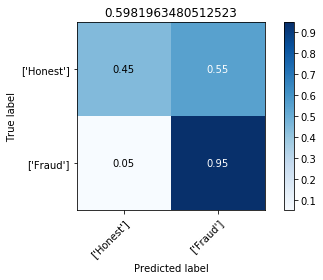

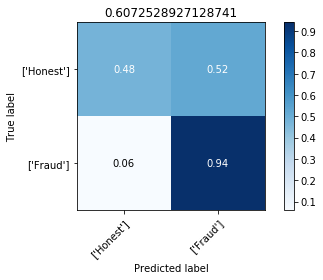

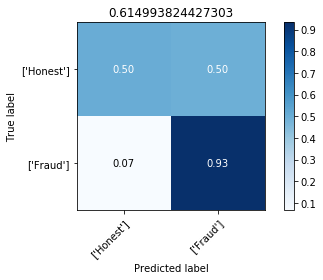

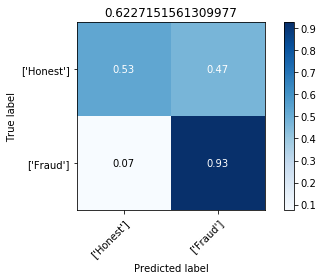

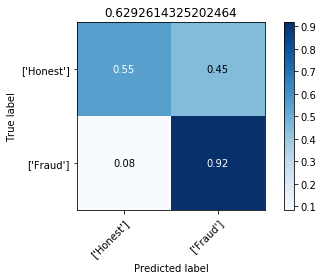

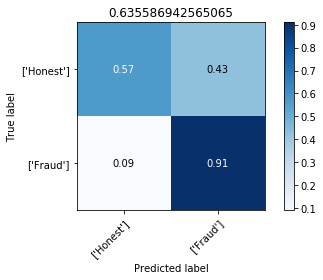

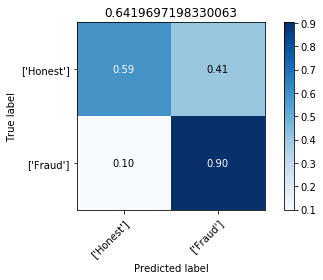

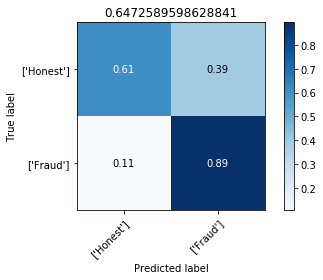

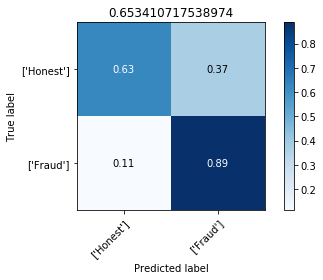

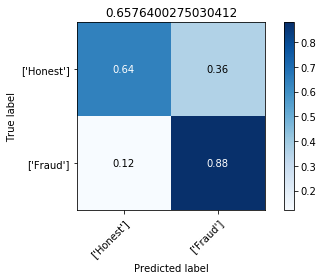

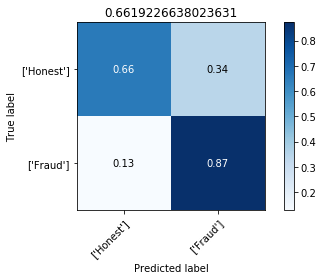

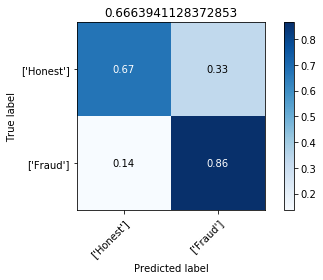

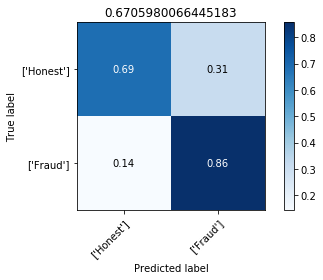

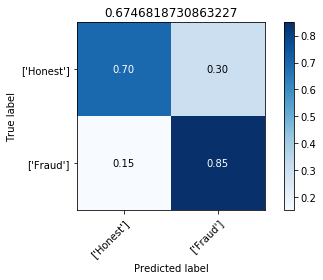

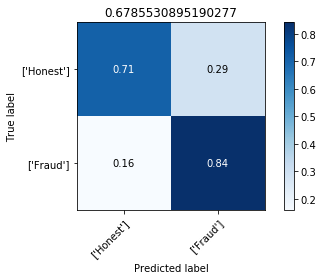

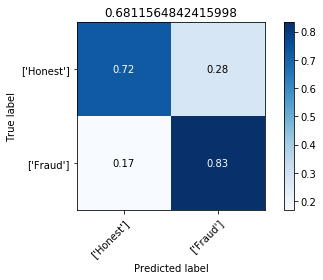

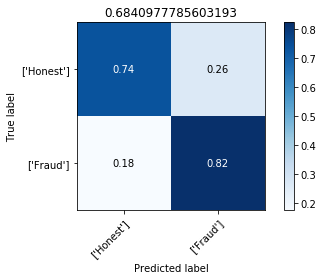

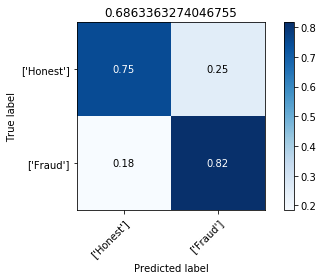

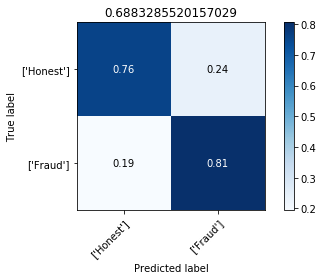

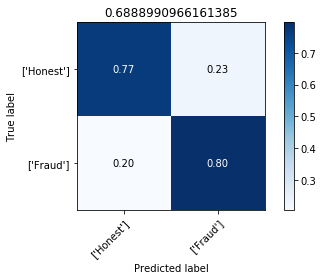

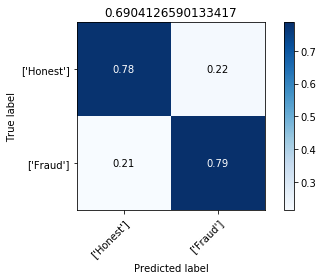

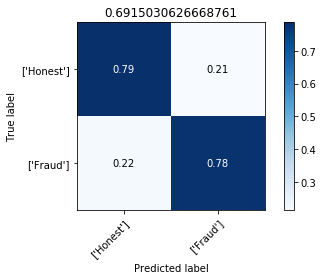

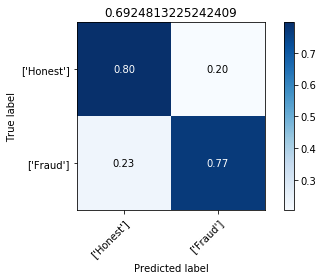

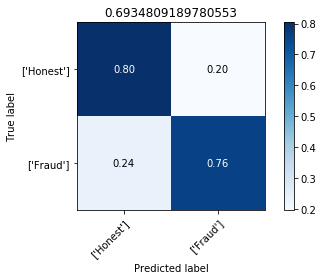

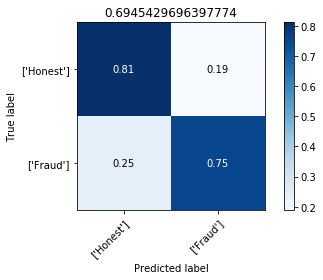

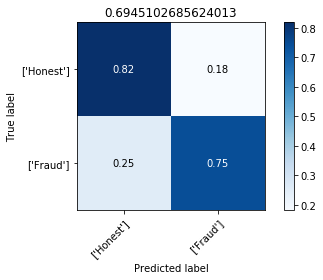

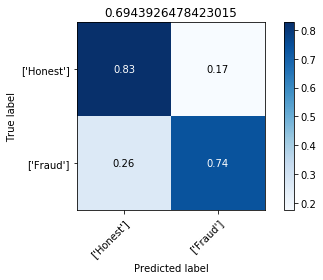

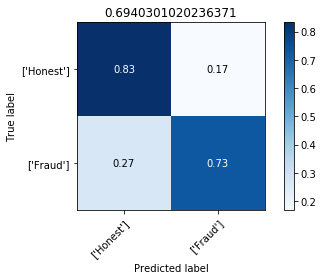

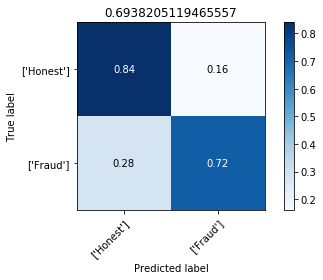

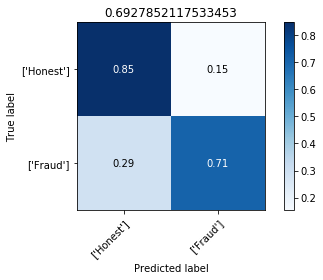

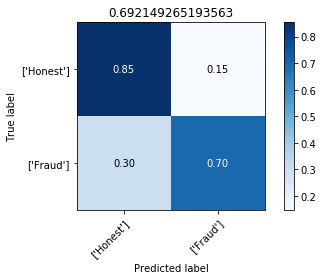

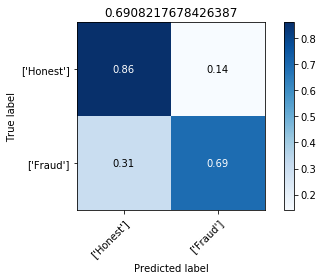

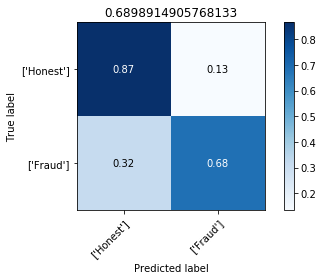

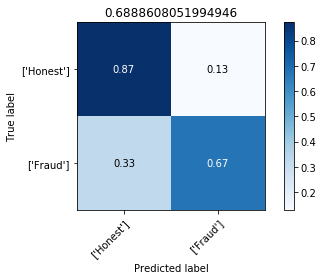

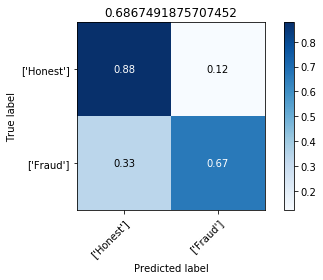

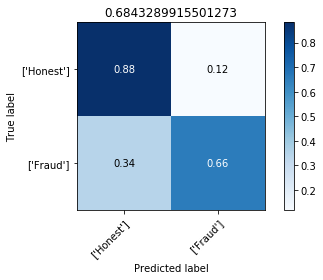

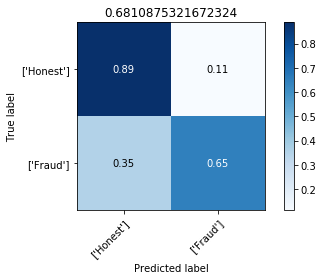

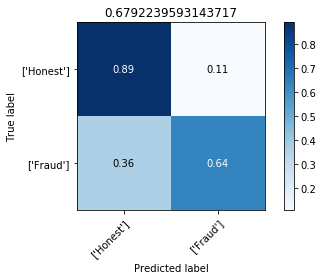

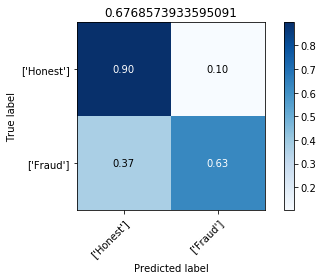

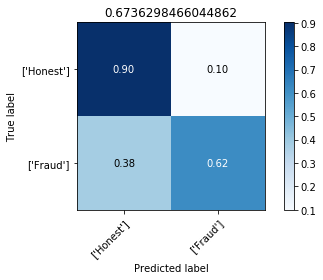

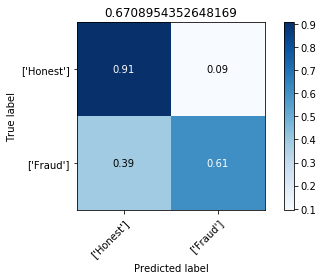

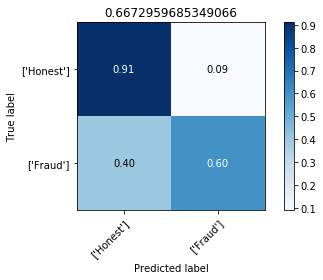

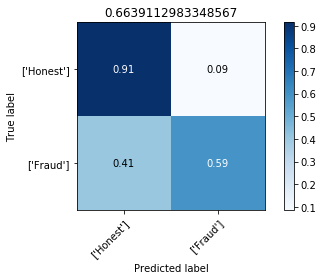

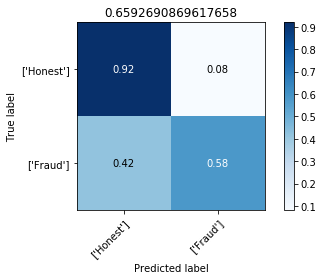

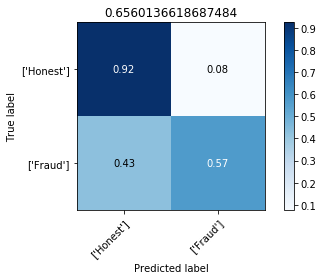

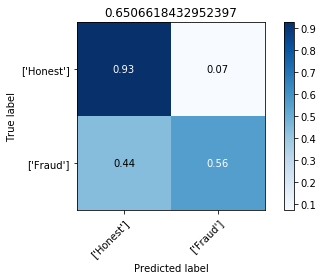

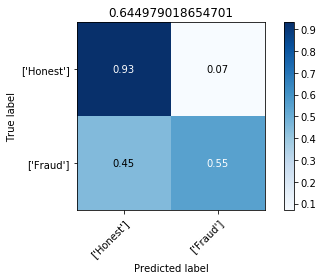

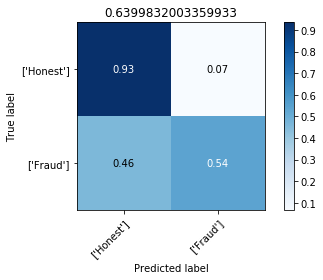

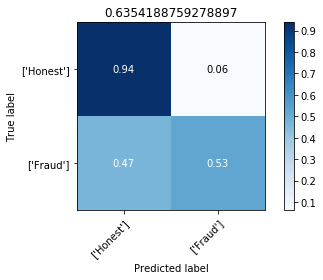

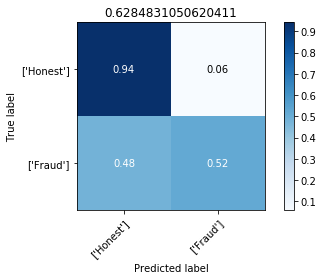

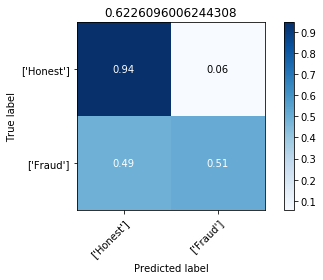

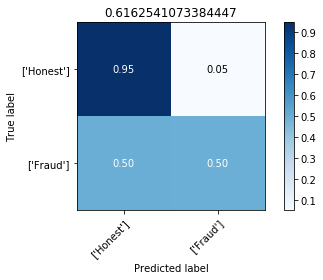

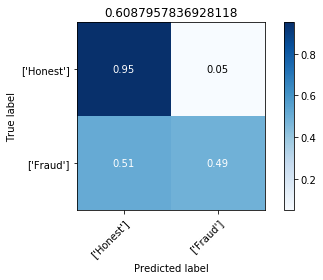

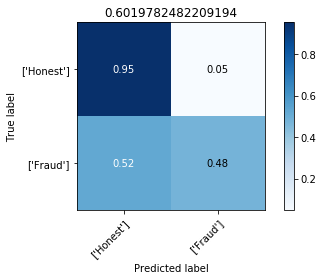

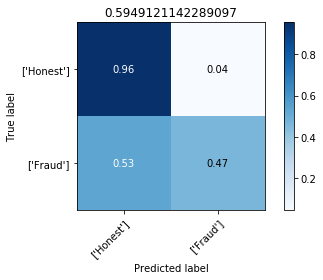

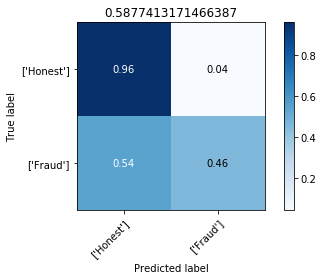

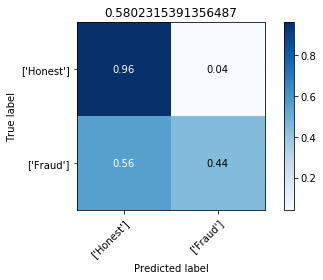

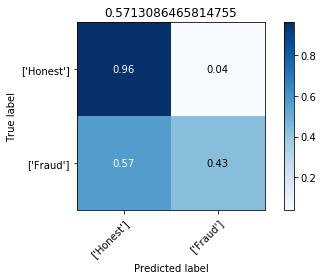

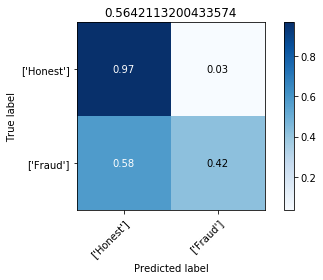

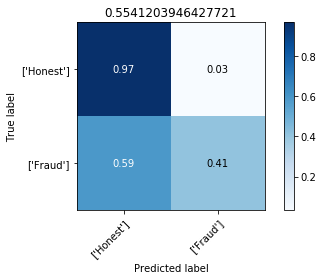

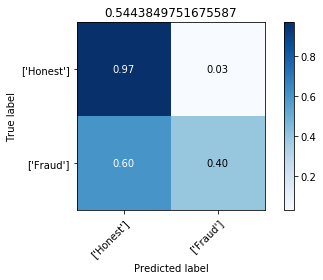

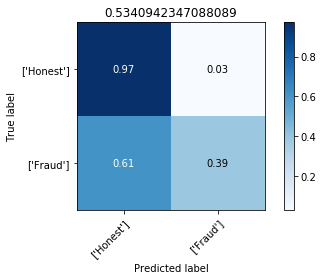

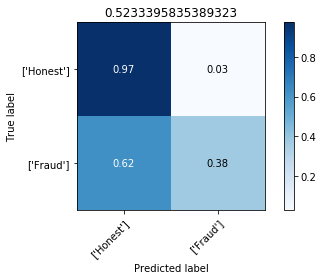

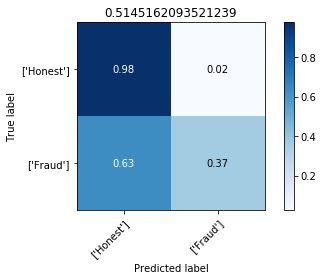

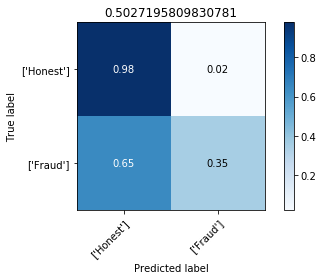

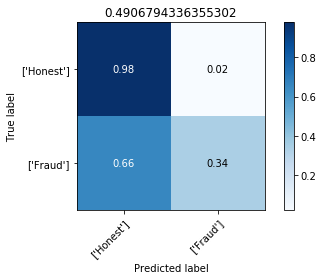

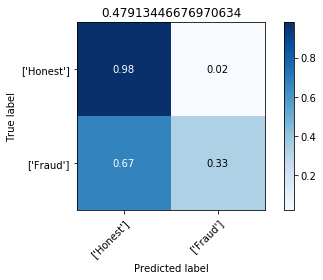

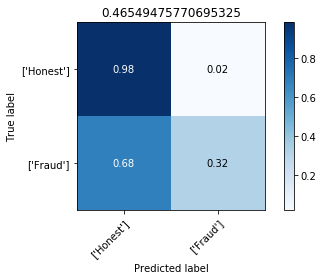

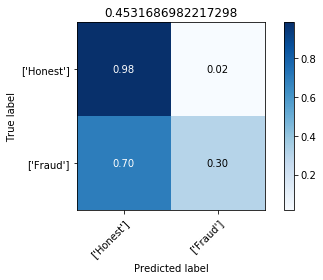

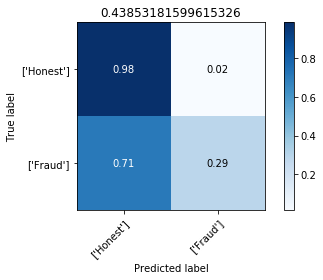

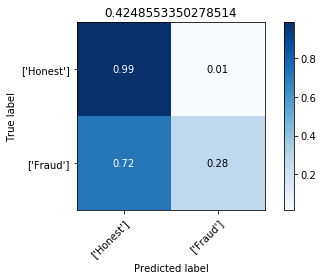

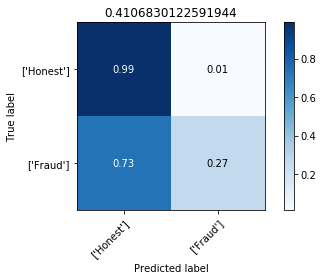

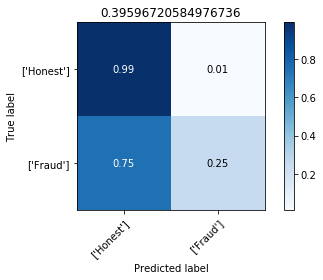

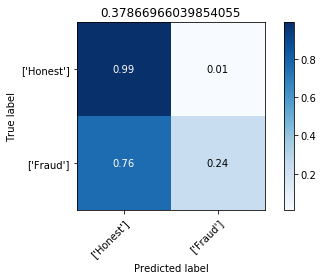

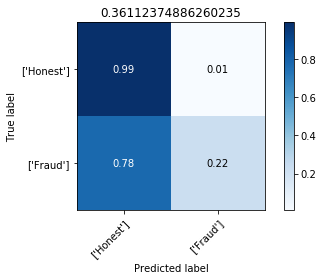

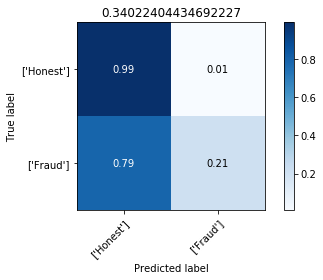

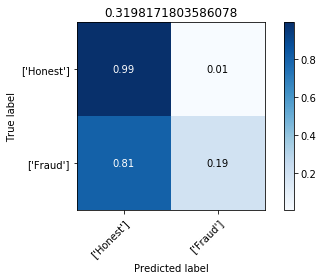

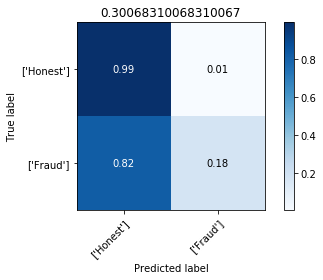

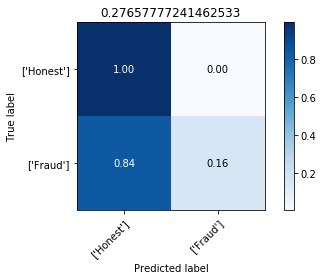

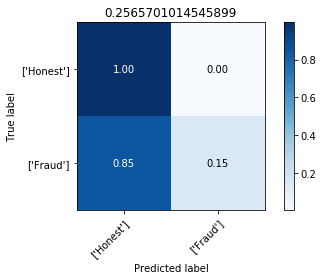

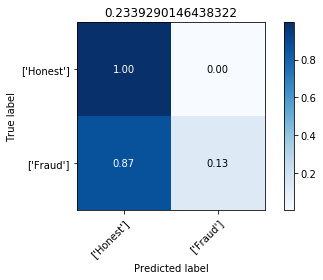

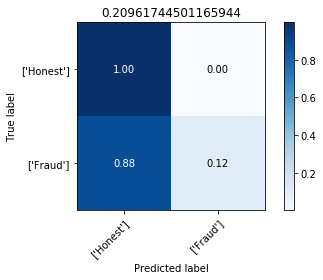

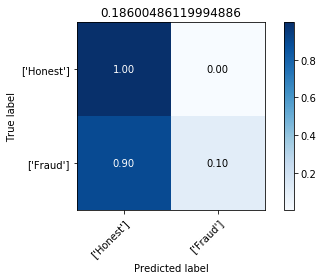

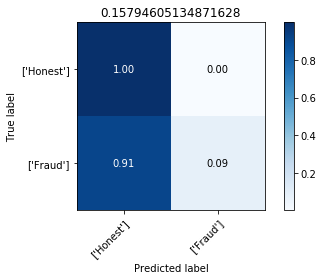

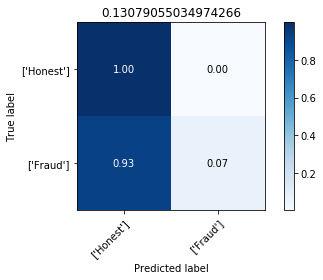

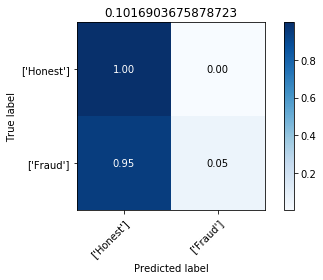

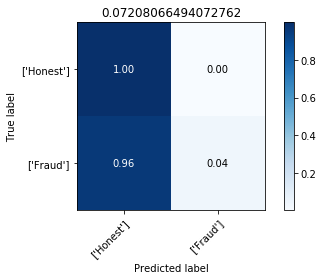

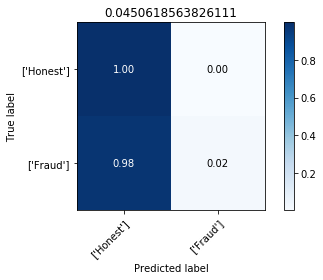

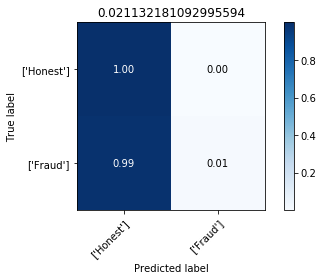

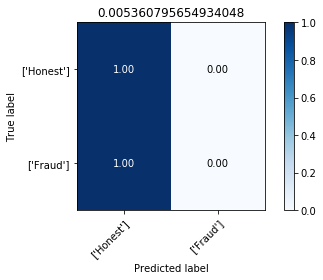

In [16]:
for i in range(len(yprob)):
    plot_confusion_matrix(y_data[0], yprob[i],
                          classes = np.array([['Honest'],['Fraud']]),
                          normalize=True,
                          title= f1[i],
                          cmap=plt.cm.Blues)